In [1]:
using Pkg
using Conda
using WebIO
using Interact
using DifferentialEquations
using DiffEqFlux
using DiffEqSensitivity, OrdinaryDiffEq, Zygote
using Plots
using Flux, Optim, Test
using Optimization, OptimizationPolyalgorithms

WebIO._IJuliaInit()

┌ Warning: OrcV2 initialization failed with
│   err = ErrorException("could not load library \"C:\\Users\\周天恒\\.julia\\artifacts\\12030a5c187a7e327b57d45e3397edf672ab442d\\bin\\libLLVMExtra-12.dll\"\nThe specified procedure could not be found. ")
└ @ Enzyme.Compiler.JIT C:\Users\周天恒\.julia\packages\Enzyme\di3zM\src\compiler\orcv2.jl:103


In [2]:
using BifurcationKit
using Revise
using SparseArrays, LinearAlgebra, DiffEqOperators, Setfield, Parameters
using GaussianProcesses
using Distributions,Random
using ForwardDiff
using MAT
using CSV
using DataFrames

┌ Info: Precompiling GaussianProcesses [891a1506-143c-57d2-908e-e1f8e92e6de9]
└ @ Base loading.jl:1423


In [3]:
gr()

Plots.GRBackend()

## True Assumption:
$$
\ddot{x}+b\dot{x}+w_{n}^{2}x+\mu x^3+vx^5+\rho x^7=\delta _{st}w_{n}^{2}\cos \left( wt \right) 
$$

$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-w_{n}^{2}x-\mu x^3-vx^5-\rho x^7+\delta _{st}w_{n}^{2}\cos \left( wt \right)\\
\end{array} \right. 
$$


## Approximate
$$
\ddot{x}+b\dot{x}+w_{n}^{2}x+\mu x^3=\delta _{st}w_{n}^{2}\cos \left( wt \right)+NN\left( x,t \right)
$$


$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-w_{n}^{2}x-\mu x^3+\delta _{st}w_{n}^{2}\cos \left( wt \right)+NN\left( x,t \right)\\
\end{array} \right. 
$$

In [4]:
function generate_data_with_noise(initial_condition, datasize, timespan, ODE_parameter,ODE_function,noise_sigma=0)
    t = range(tspan[1],tspan[2],length=datasize)
    prob = ODEProblem(ODE_function,initial_condition,timespan,ODE_parameter)
    sol = Array(solve(prob,Tsit5(),saveat=t))
    noise = rand(Normal(0,noise_sigma),datasize)
    sol[1,:] = sol[1,:] + noise
    return sol
end

generate_data_with_noise (generic function with 2 methods)

In [5]:
initial = [1.0,0.0]
datasize = 30
tspan = (0.0,10)
#parameter value from the Robust paper
#b,wn_2,mu,v,rho,delta_st,w
param = [0.3159,1,1.499,-0.3921,0.0422,1,round(2*pi*19.95,digits = 3)]
t = range(tspan[1],tspan[2],length=datasize)

function Duffing!(du,u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y = u
    du[1] = y
    du[2] = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * cos(w*t)
    du
end

Duffing! (generic function with 1 method)

In [6]:
p = plot()
for (i,sig) in enumerate([0,0.01,0.05,0.1,0.2])
    data = generate_data_with_noise(initial,datasize,tspan,param,Duffing,sig)
    plot!(p,range(tspan[1],tspan[2],length=datasize),data[1,:],label = "sigma = $(sig)")
    scatter!(p,range(tspan[1],tspan[2],length=datasize),data[1,:],label = "")
    if i == length(enumerate([0,0.01,0.05,0.1,0.5]))
        display(p)
    end

    #plot!(range(tspan[1],tspan[2],length=datasize),data[1,:],label = "sigma = $(sig)")

    
end

LoadError: UndefVarError: Duffing not defined

In [7]:
p = plot()
tspan = (0,50)
for i in -10:5:10
    for j in -10:5:10
        init = [i,j]
        data = generate_data_with_noise(init,50,tspan,param,Duffing,0)
        plot!(p,range(tspan[1],tspan[2],length=50),data[1,:],label = "")
        #scatter!(p,range(tspan[1],tspan[2],length=50),data[1,:],label = "")
        if i == 10 && j ==10
            xlabel!(p,"t")
            ylabel!(p,"x")
            display(p)
        end
    end
end
        
        

LoadError: UndefVarError: Duffing not defined

## Bifurcation

In [8]:
const BK = BifurcationKit
norminf(x) = norm(x, Inf)
parlor = (b = param[1],wn_2 = param[2],mu = param[3],v=param[4],rho=param[5],delta_st=param[6],w=param[7])
recordFromSolution(x, p) = (x = x[1], y = x[2])

Duffing(z, p) = Duffing!(similar(z), z, p, 0)

Duffing (generic function with 1 method)

In [9]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.wn_2);recordFromSolution)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ inplace:  false
├─ Symmetric: false
└─ Parameter: wn_2

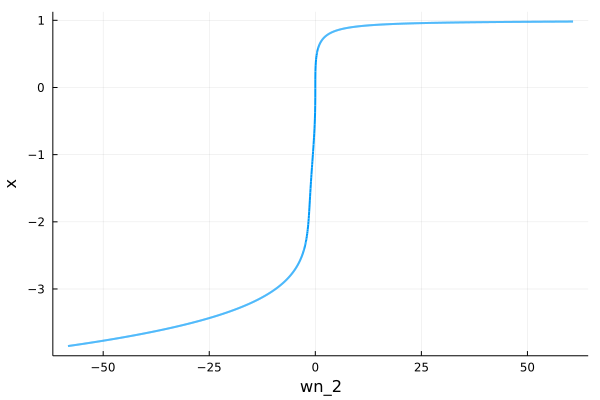

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [10]:
opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

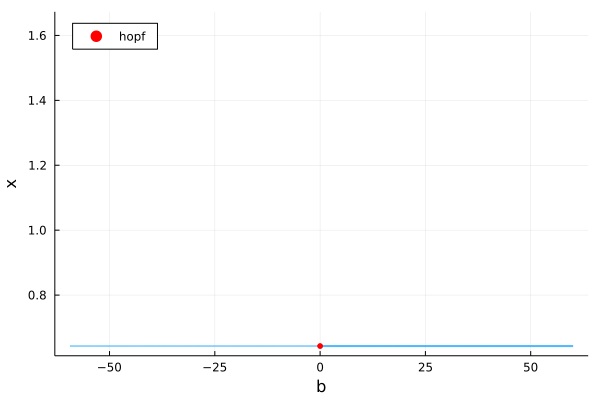

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [11]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.b);recordFromSolution)

opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

┌ Error: Failure to converge with given tolerances.
└ @ BifurcationKit C:\Users\周天恒\.julia\packages\BifurcationKit\temnd\src\continuation\Contbase.jl:73


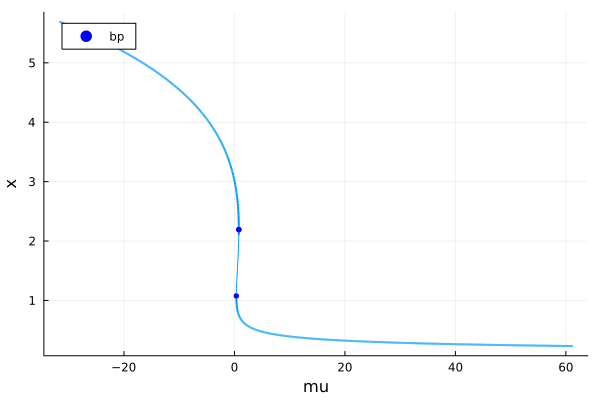

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [12]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.mu);recordFromSolution)

opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

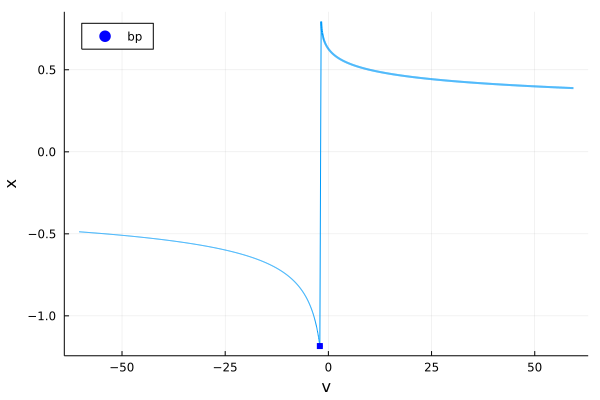

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [13]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.v);recordFromSolution)

opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

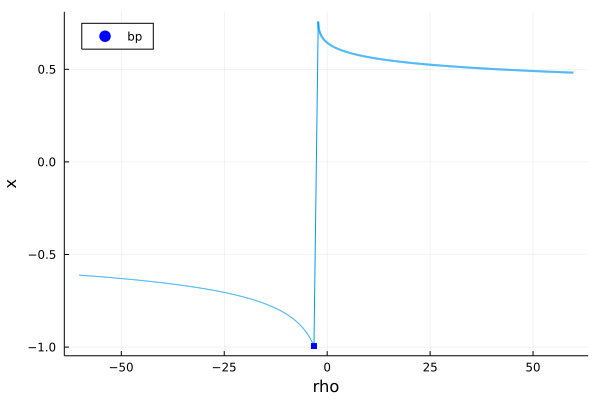

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [14]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.rho);recordFromSolution)

opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

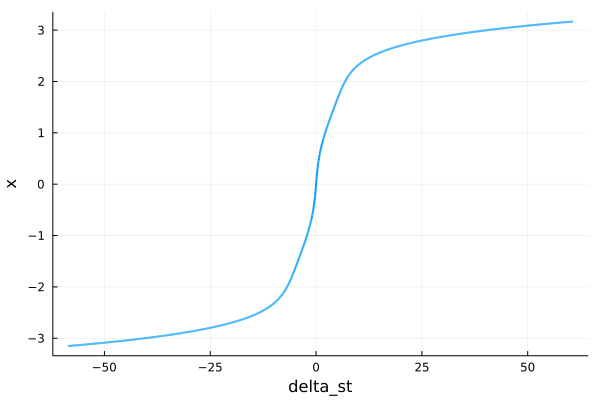

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [15]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.delta_st);recordFromSolution)

opts_br = ContinuationPar(pMin = -100.0, pMax = 100.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

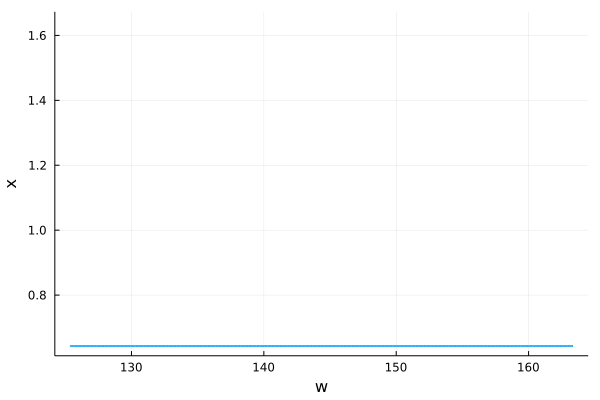

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [16]:
prob = BifurcationProblem(Duffing, initial, parlor, (@lens _.w);recordFromSolution)

opts_br = ContinuationPar(pMin = 2*pi*19.95, pMax = 2*pi*26.0, ds = 0.04, dsmax = 0.05, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

@set! opts_br.newtonOptions.verbose = false


br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)

In [17]:
p = plot()
for (i,omega) in enumerate(2*pi.*[20.0,22.0,22.5,23.0,24.0,26.0])
    #println(omega)
    par = (b = param[1],wn_2 = param[2],mu = param[3],v=param[4],rho=param[5],delta_st=param[6],w=omega)
    prob = BifurcationProblem(Duffing, initial, par, (@lens _.delta_st);recordFromSolution)

    opts_br = ContinuationPar(pMin = -20.0, pMax = 20.0, ds = 0.001, dsmax = 0.01, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 50, nev = 3, plotEveryStep = 20, maxSteps = 1000, θ = 0.3)

    @set! opts_br.newtonOptions.verbose = false
    br = continuation(prob, PALC(tangent=Bordered()), opts_br;bothside = true, normC = norminf)

    plot!(p, br, plotfold=false, markersize=3, legend=:topleft,label = "$(i)")
    if i == length(enumerate(2*pi.*[20.0,22.0,22.5,23.0,24.0,26.0]))
        display(p)
    end
end

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


## Data

In [18]:
file = MAT.matread("measurement_data/measurement_data/noise/cbc_f24_noise_N0/bp1.mat")


Dict{String, Any} with 2 entries:
  ""            => UInt8[0x00 0x01 … 0x00 0x00]
  "branchpoint" => Dict{String, Any}("out_coeffs"=>[0.0 0.2 … 0.0 0.0], "gains"…

In [19]:
transpose(file["branchpoint"]["stream"])

5000×9 transpose(::Matrix{Float64}) with eltype Float64:
 1.05169e8  -0.05483     0.264511  …  -0.0432587   2.38604    6.03564
 1.05169e8  -0.0490052   0.265656     -0.0434113   2.26581    6.0658
 1.05169e8  -0.0431358   0.265427     -0.0434875   2.05207    6.09596
 1.05169e8  -0.0372271   0.266037     -0.0437927   1.8027     6.12612
 1.05169e8  -0.0312846   0.266266     -0.0430298   1.5051     6.15628
 1.05169e8  -0.0253136   0.267715  …  -0.0434113   1.21788    6.18644
 1.05169e8  -0.0193197   0.268173     -0.0437164   0.960354   6.2166
 1.05169e8  -0.0133081   0.268555     -0.0439453   0.644194   6.24676
 1.05169e8  -0.00728443  0.268478     -0.0440979   0.372564   6.27691
 1.05169e8  -0.00125413  0.268555     -0.0440216   0.0957385  0.0238886
 1.05169e8   0.00477726  0.26825   …  -0.0441742  -0.155111   0.0540479
 1.05169e8   0.0108043   0.269394     -0.0440979  -0.395571   0.0842072
 1.05169e8   0.0168215   0.268555     -0.0442505  -0.592985   0.114366
 ⋮                          

In [20]:
d = CSV.read("measurement_data/measurement_data/noise/cbc_f24_noise_N0/base_accel.dat",delim=' ', ignorerepeated=true,DataFrame)

5000×2 DataFrame
  Row │ time     base_acc   
      │ Float64  Float64    
──────┼─────────────────────
    1 │  0.0002   3.5349
    2 │  0.0004   5.95212
    3 │  0.0006   4.83146
    4 │  0.0008   7.81493
    5 │  0.001    8.37452
    6 │  0.0012   9.22949
    7 │  0.0014  11.4122
    8 │  0.0016  11.0174
    9 │  0.0018  14.127
   10 │  0.002   12.9677
   11 │  0.0022  15.5178
  ⋮   │    ⋮         ⋮
 4991 │  0.9982  -1.66837
 4992 │  0.9984   0.17886
 4993 │  0.9986  -0.196672
 4994 │  0.9988   0.983361
 4995 │  0.999   -0.987814
 4996 │  0.9992   0.71173
 4997 │  0.9994  -0.456428
 4998 │  0.9996   2.05652
 4999 │  0.9998   1.37671
 5000 │  1.0      3.37534
           4979 rows omitted

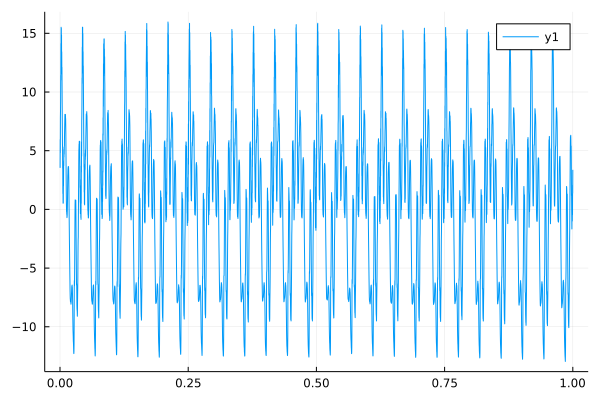

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [21]:
plot(d[:,:time],d[:,:base_acc])

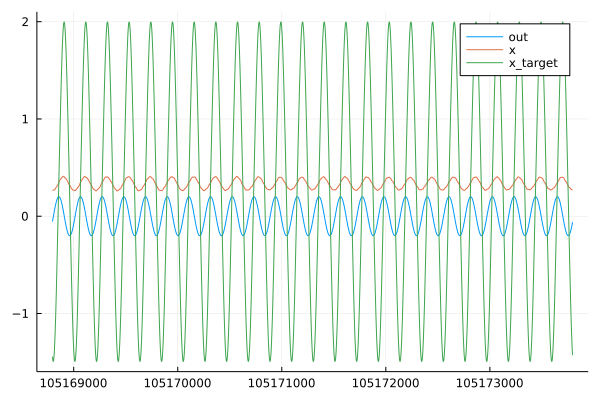

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [22]:
plot(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,2],label = "out")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,3],label = "x")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,4],label = "x_target")



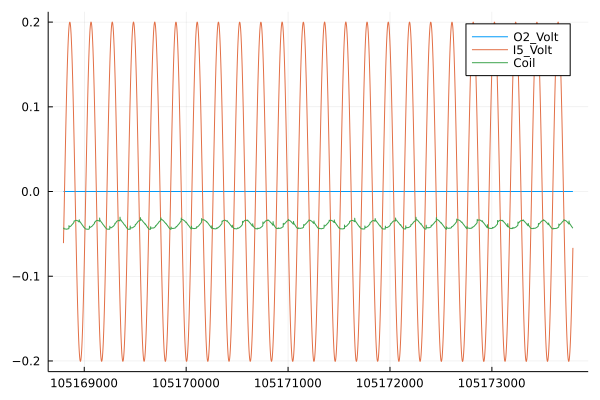

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [23]:
plot(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,5],label = "O2_Volt")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,6],label = "I5_Volt")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,7],label = "Coil")


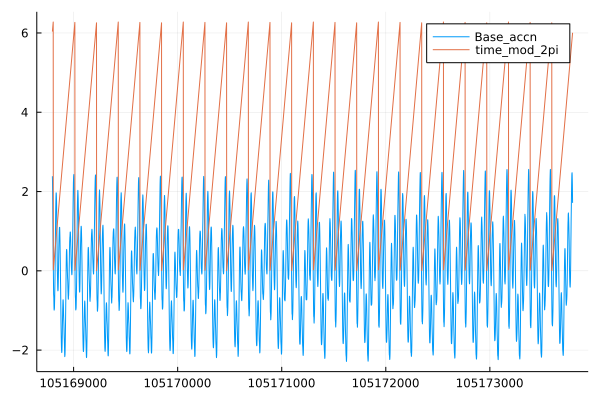

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [24]:
plot(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,8],label = "Base_accn")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,9],label = "time_mod_2pi")

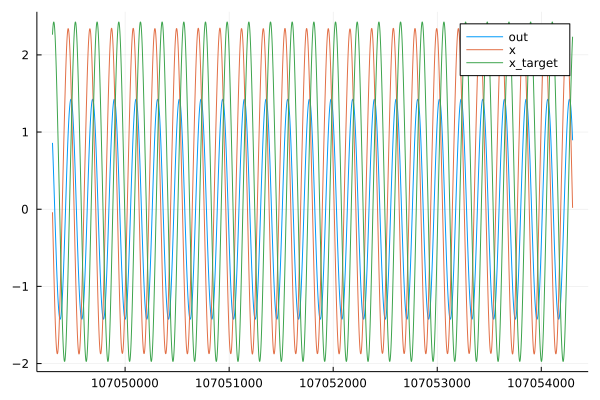

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [25]:
file = MAT.matread("measurement_data/measurement_data/noise/sw_f24_noise_N0/bp50.mat")
plot(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,2],label = "out")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,3],label = "x")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,4],label = "x_target")

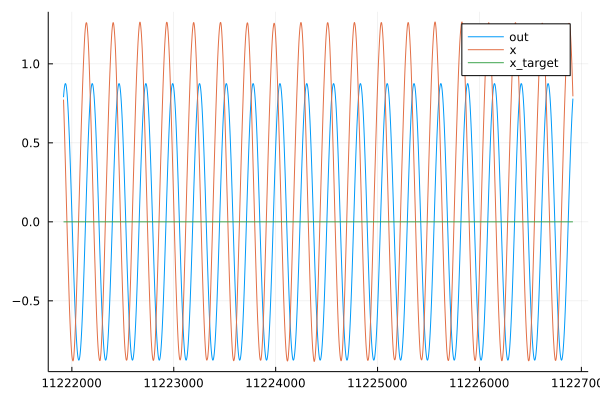

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1w4OWMyYmE3Y2M5MTBhNWE2Nzk5ZDI3NzM1NDIyZDQwNDBjYWVmYzhmXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXDg5YzJiYTdjYzkxMGE1YTY3OTlkMjc3MzU0MjJkNDA0MGNhZWZjOGZcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [26]:
file = MAT.matread("measurement_data/measurement_data/sw/sw_A0.875_noise_0m1/bp1.mat")
plot(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,2],label = "out")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,3],label = "x")
plot!(transpose(file["branchpoint"]["stream"])[:,1],transpose(file["branchpoint"]["stream"])[:,4],label = "x_target")